In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import pandas as pd
from scipy import stats
import re
from scipy.stats.stats import pearsonr
#import rpy2.robjects as robjects
import random
from statsmodels.stats.multitest import fdrcorrection
import os
import seaborn as sns
#import gseapy as gs
from scipy.stats import norm
import gseapy as gs

min_gen = 6
max_gen = 300

#List of imprinted genes was obtained from https://www.geneimprint.com/site/genes-by-species
imp = pd.read_csv("Imprinted_Genes.csv")
imp_conf = imp[imp["Status"] == "Imprinted"]
imp_conf_list = list(imp_conf["Gene"])

In [19]:
from scipy.stats import spearmanr
v = pd.read_csv("D50_Ranks_FLIP_GTEX.csv")
v2 = pd.read_csv("D50_Ranks_GTEX.csv")
d = {}
for index, row in v.iterrows():
    d[row["gene"]] = [row["MWU p-val DESeq2 p-val Rank Rank Dif"]]
for index, row in v2.iterrows():
    d[row["gene"]].append(row["MWU p-val DESeq2 p-val Rank Rank Dif"])
cor1 = []
cor2 = []
for key in d.keys():
    val = d[key]
    cor1.append(val[0])
    cor2.append(val[1])
print(spearmanr(cor1, cor2))

SpearmanrResult(correlation=0.9991801632881288, pvalue=0.0)


In [14]:
i = 0
for cell in ["D50", "D100", "D150"]:
    for data in ["GTEX"]:
        c = 0
        p = pd.read_csv(cell + "_" + data + "_MinReads_Per_Allele10MWU_ASE_Ratios_Median1_FLIP.txt", sep = "\t")
        v = pd.read_csv("Rachel_ASE_Values_" + cell + "_NoNA.csv")
        v = v.set_index("Gene")
        p = p.set_index('gene')
        vp = p.join(v)
        #vp = vp[~vp["fdr"].dropna()]
        out = []
        for index, row in vp.iterrows():
            #t = 
            if (row["Sample Size"]) >= 10:
                c += 1
            if data == "Stein":
                if row["pval"] != 0 and row["Sample Size"] >= 10:
                    out.append([index, (abs(row[cell + "_HumanLFC"]) + abs(row[cell + "_ChimpLFC"]))/2, row["pval"], (abs(row[cell + "_HumanPadj"]) + abs(row[cell + "_ChimpPadj"]))/2])
            if data == "GTEX":
                if row["pval"] != 0 and row["Sample Size"] >= 50:
                    out.append([index, (abs(row[cell + "_HumanLFC"]) + abs(row[cell + "_ChimpLFC"]))/2, row["pval"], (abs(row[cell + "_HumanPadj"]) + abs(row[cell + "_ChimpPadj"]))/2])
        if data == "Stein":
            print(c)
        df = pd.DataFrame(out)
        df.columns = ["0", "L2FC Score", "ASE p-val Score", "DESeq2 p-val Score"]
        df.to_csv(cell + "_Scores_FLIP_" + data + ".csv", index = False)

In [17]:
#Computes ranks and differences in ranks
#Generates a consensus best ranking incorporating the ASE MWU p-value and the DESeq2 p-value
#Splits list into DESeq2 pval <= 0.1 and > 0.1 then sorts based on ASE MWU p-value or L2FC p-value.  
#Helps avoid false positives at the top of the list this way.
cells = ["D50", "D100", "D150"]
data = ["GTEX"]
for cell in cells:
    for dat in data:
        v = pd.read_csv(cell + "_Scores_FLIP_" + dat + ".csv").dropna()
        vl1 = v.loc[v["DESeq2 p-val Score"] <= 0.1]
        vg1 = v.loc[v["DESeq2 p-val Score"] > 0.1]
        d = {}
        for index, row in v.iterrows():
            d[row[0]] = []

        c_mwu = len(list(d.keys()))
        c_pval = len(list(d.keys()))
        c_l2fc = len(list(d.keys()))
        vl1 = vl1.sort_values("ASE p-val Score")
        for index, row in vl1.iterrows():
            d[row[0]].append(c_mwu)
            c_mwu -= 1
        vg1 = vg1.sort_values("ASE p-val Score")
        for index, row in vg1.iterrows():
            d[row[0]].append(c_mwu)
            c_mwu -= 1

        vl1 = vl1.sort_values("L2FC Score", ascending = False)
        for index, row in vl1.iterrows():
            d[row[0]].append(c_l2fc)
            c_l2fc -= 1
        vg1 = vg1.sort_values("L2FC Score", ascending = False)
        for index, row in vg1.iterrows():
            d[row[0]].append(c_l2fc)
            c_l2fc -= 1

        vl1 = vl1.sort_values("DESeq2 p-val Score")
        for index, row in vl1.iterrows():
            d[row[0]].append(c_pval)
            c_pval -= 1
        vg1 = vg1.sort_values("DESeq2 p-val Score")
        for index, row in vg1.iterrows():
            d[row[0]].append(c_pval)
            c_pval -= 1

        out = []
        for key in d.keys():
            out.append([key] + d[key])
        df = pd.DataFrame(out)
        df[4] = df[1] - df[3]
        df[5] = df[1] - df[2]
        df.columns = ["gene", "MWU p-val Rank", "L2FC Rank", "DESeq2 p-val Rank", "MWU p-val DESeq2 p-val Rank Rank Dif", "MWU p-val L2FC Rank Rank Dif"]
        df.dropna().to_csv(cell + "_Ranks_FLIP_" + dat + ".csv", index = False)

In [ ]:
#Compute the binomial test on all genes in a certain category (folder is fi)
#Need to use shell script to move all the GSEA results to that folder.
def extract_gene_info(genes, cell, data):
    scores = pd.read_csv(cell + "_Scores_" + data + "_Ranked.csv")
    ase = pd.read_csv("Rachel_ASE_Values_" + cell + ".csv").set_index("Gene")
    scores = scores.set_index("0")
    c_neg = 0
    tot = 0
    out = []
    for gene in genes.split(";"):
        score = list(scores.loc[gene])
        score[0] = (ase.loc[gene][0] + ase.loc[gene][1])/2
        out.append([gene] + score)
        if (ase.loc[gene][0] + ase.loc[gene][1])/2 < 0:
            c_neg += 1
            tot += 1
        elif (ase.loc[gene][0] + ase.loc[gene][1])/2 > 0:
            tot += 1
    
    df = pd.DataFrame(out)
    l = list(scores.columns)
    l[0] = "L2FC signed"
    df.columns = ["Gene"] + l
    #df.to_csv("Ledge_genes_info_" + name + "_" + cell + "_" + data + "_" + comp + ".csv", index = False)
    return stats.binom_test(c_neg, tot, 0.5), c_neg, tot

fi = "AGSEA_MWU_p-val_DESeq2_p-val_Rank_Rank_Dif"
f = os.listdir(fi)
o = []
for file in f:
    c = file.split("_")[1]
    d = file.split("_")[0]
    v = pd.read_csv(os.path.join(fi, file))
    for index, row in v.iterrows():
        if row["fdr"] < 0.25 and row["nes"] > 0 and len(row["ledge_genes"].split(";")) > 10:
            r = list(row)
            r = [file] + r
            q = extract_gene_info(row["ledge_genes"], c, d)
            r = r + list(q)
            o.append(r)
df = pd.DataFrame(o)
df.columns = ["File", "Term", "ES", "NES", "p-val", "FDR", "Total Genes in Geneset", "Intersect with our Gene Set", "Genes", "ledge genes", "Binomial p-val", "Down in Human", "Total"]

In [ ]:
#Finish with fdr correction after filtering out categories that appear multiple times to avoid testing the same hypothesis.
from statsmodels.stats.multitest import fdrcorrection
d = {}
for index, row in df.iterrows():
    key = row["Term"]
    val = row
    if key in d.keys():
        d[key].append(val)
    else:
        d[key] = [val]
o = []
for key in d.keys():
    l = d[key]
    m = 100000
    m_pos = 0
    if len(l) > 1:
        for i in range(len(l)):
            j = l[i]
            if i == 0:
                m = j["FDR"]
            else:
                if j["FDR"] < m:
                    m = j["FDR"]
                    m_pos = i
        o.append(l[m_pos])
    else:
        o.append(l[0])
df = pd.DataFrame(o)
df.columns = ["File", "Term", "ES", "NES", "p-val", "FDR", "Total Genes in Geneset", "Intersect with our Gene Set", "Genes", "ledge genes", "Binomial p-val", "Down in Human", "Total"]
to_cor = list(df["Binomial p-val"])
corred = fdrcorrection(to_cor)
df["FDR Sign Test"] = corred[1]

df.to_csv("AGSEA_MWU_p-val_DESeq2_p-val_Rank_Rank_Dif_SignTest_Fixed.csv", index = False)

In [ ]:
#Interesting observation that most enrichments are dominated by chimpanzee down genes.
stats.binom_test(237, 291, 0.5)

In [6]:
#Haploinsufficient genes from https://github.com/macarthur-lab/gene_lists/blob/master/lists
#Extract gene info for haploinsufficient genes and compute binomial test statistic.
v = pd.read_csv("Haploinsufficient_Genes.csv", header = None)
d = {}
cells = ["D50", "D100", "D150"]
d["Haploinsufficient"] = list(v[0])
dat = ["GTEX", "Stein"]
def extract_gene_info(genes, cell, data):
    name = "Haploinsufficient"
    scores = pd.read_csv(cell + "_Scores_" + data + ".csv")
    ase = pd.read_csv("Rachel_ASE_Values_" + cell + ".csv").set_index("Gene")
    scores = scores.set_index("0")
    c_neg = 0
    tot = 0
    out = []
    for gene in genes.split(";"):
        try:
            score = list(scores.loc[gene])
            score[0] = (ase.loc[gene][0] + ase.loc[gene][1])/2
            out.append([gene] + score)
            if (ase.loc[gene][0] + ase.loc[gene][1])/2 < 0:
                c_neg += 1
                tot += 1
            elif (ase.loc[gene][0] + ase.loc[gene][1])/2 > 0:
                tot += 1
        except:
            pass
    df = pd.DataFrame(out)
    l = list(scores.columns)
    l[0] = "L2FC signed"
    df.columns = ["Gene"] + l
    df.to_csv("Ledge_genes_info_" + name + "_" + cell + "_" + data + ".csv", index = False)
    return cell, data, stats.binom_test(c_neg, tot, 0.5), c_neg, tot
for cell in cells:
    for da in dat:
        print(extract_gene_info(";".join(d["Haploinsufficient"]), cell, da))

('D50', 'GTEX', 0.7432690217670561, 72, 149)
('D50', 'Stein', 0.999999999999999, 40, 81)
('D100', 'GTEX', 0.9345249854170996, 73, 148)
('D100', 'Stein', 0.8243132151052075, 42, 81)
('D150', 'GTEX', 0.051523568581622325, 82, 140)
('D150', 'Stein', 0.013999473719986937, 52, 81)


In [4]:
#P-value for just brain related genes (hand curated) is consistent with D150 Stein having significant bias toward down in chimp. 
#Note: For the brain associated haploinsufficiency. 
#If there was any mention of brain in associated syndromes or in the clingen page it counted as brain.
#If not, it was not brain.
#This website was used for symptoms: https://rarediseases.info.nih.gov/diseases/7784/townes-brocks-syndrome
stats.binom_test(40, 62, 0.5)

0.03001586434906731

In [40]:
#Extracts gene info.
def extract_gene_info(genes, cell, data):
    name = "Other_Glycan_Degradation"
    scores = pd.read_csv(cell + "_Scores_" + data + ".csv")
    ase = pd.read_csv("Rachel_ASE_Values_" + cell + ".csv").set_index("Gene")
    scores = scores.set_index("0")
    c_neg = 0
    tot = 0
    out = []
    for gene in genes.split(";"):
        try:
            score = list(scores.loc[gene])
            score[0] = (ase.loc[gene][0] + ase.loc[gene][1])/2
            out.append([gene] + score)
            if (ase.loc[gene][0] + ase.loc[gene][1])/2 < 0:
                c_neg += 1
                tot += 1
            elif (ase.loc[gene][0] + ase.loc[gene][1])/2 > 0:
                tot += 1
        except:
            pass
    df = pd.DataFrame(out)
    l = list(scores.columns)
    l[0] = "L2FC signed"
    df.columns = ["Gene"] + l
    df.to_csv("Ledge_genes_info_" + name + "_" + cell + "_" + data + ".csv", index = False)
    return cell, data, stats.binom_test(c_neg, tot, 0.5), c_neg, tot
extract_gene_info("MANBA;MAN2B1;MAN2B2;NEU3;FUCA2;ENGASE", "D50", "GTEX")

('D50', 'GTEX', 0.03125, 0, 6)

In [23]:
#Binomial test not significant at all for glycoside hydrolases.
csv = pd.read_csv("Rachel_ASE_Values_D50.csv")
gs = pd.read_csv("Glycoside_Hydrolases.csv")
l = []
neg = 0
tot = 0
genes = []
for index, row in gs.iterrows():
    l.append(row[0].replace(" ", ""))
for index, row in csv.iterrows():
    if row[0] == "MANBA":
        print(True)
    if row[0] in l:
        if (row[1] + row[2])/2 < 0:
            neg += 1
            tot += 1
        elif (row[1] + row[2])/2 > 0:
            tot += 1
        genes.append(row[0])
print(neg, tot, stats.binom_test(neg, tot, 0.5))

True
28 55 1.0


In [46]:
#Get the percentage in the cerebrum that have less expression than non-neural tissues.
z = pd.read_csv("Glycosylation_Expression_Tissue.csv")
d = {}
num = 4
for index, row in z.iterrows():
    tb = 0
    c = 0
    for i in row:
        if c == 0:
            d[i] = 0
        elif c == num:
            tb = i
        c += 1
    c = 0
    g = 0
    for i in row:
        if c:
            c += 1
            if c not in [3, 4, 5]:
                if i > tb:
                    d[g] += 1
        else:
            c += 1
            g = i
for key in d.keys():
    d[key] = [d[key], 12- d[key], stats.binom_test(d[key], 12, 0.5)]
d

{'ENGASE': [12, 0, 0.00048828125],
 'NEU3': [9, 3, 0.14599609375000003],
 'MANBA': [9, 3, 0.14599609375000003],
 'MAN2B2': [11, 1, 0.006347656250000001],
 'MAN2B1': [11, 1, 0.006347656250000001],
 'FUCA2': [11, 1, 0.006347656250000001]}

In [55]:
#Compute the proportion of genes with < 2 tissues with lower expression
v = pd.read_csv("gene_expression_tissue.txt", sep = ",")
d = {}
for index, row in v.iterrows():
    tb = 0
    c = 0
    for i in row:
        if c == 0:
            d[i] = 0
        elif c == num:
            tb = i
        c += 1
    c = 0
    g = 0
    for i in row:
        if c:
            c += 1
            if c not in [3, 4, 5]:
                if i > tb:
                    d[g] += 1
        else:
            c += 1
            g = i

In [61]:
c1 = 0
for k in d.keys():
    if d[k] >= 11:
        c1 += 1
p = c1/len(d.keys())

In [63]:
#Binomial test to determine things.
stats.binom_test(4, 6, p)

0.004807762385025613

In [47]:
tips = sns.load_dataset("tips")
tips
out = []
for key in d.keys():
    out.append([key, d[key][0], "Tissues with Higher Expression Than Brain"])
    out.append([key, d[key][1], "Tissues with Lower Expression Than Brain"])
df = pd.DataFrame(out)
df.columns = ["Gene", "Count", "Type"]

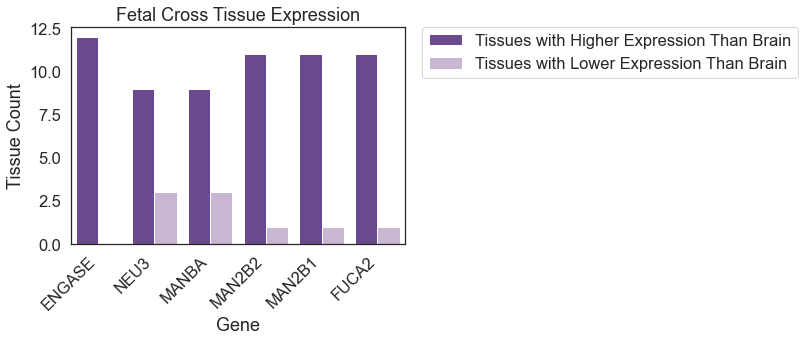

In [49]:
sns.set(font_scale = 1.5)
sns.set_style("white")
palette = {"Tissues with Higher Expression Than Brain": "#6A3D9A", "Tissues with Lower Expression Than Brain": "#CAB2D6"}
ax = sns.barplot(x="Gene", y="Count", hue="Type", data=df, palette = palette).set(title = "Fetal Cross Tissue Expression" , ylabel = "Tissue Count")
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor= (1.05, 1), loc='upper left', borderaxespad=0, frameon=True)

In [40]:
#Same for cerebellum
z = pd.read_csv("Glycosylation_Expression_Tissue.csv")
d = {}
num = 3
for index, row in z.iterrows():
    tb = 0
    c = 0
    for i in row:
        if c == 0:
            d[i] = 0
        elif c == num:
            tb = i
        c += 1
    c = 0
    g = 0
    for i in row:
        if c:
            c += 1
            if c not in [3, 4, 5]:
                if i > tb:
                    d[g] += 1
        else:
            c += 1
            g = i
for key in d.keys():
    d[key] = [d[key], 12, stats.binom_test(d[key], 12, 0.5)]
d

{'ENGASE': [12, 12, 0.00048828125],
 'NEU3': [9, 12, 0.14599609375000003],
 'MANBA': [11, 12, 0.006347656250000001],
 'MAN2B2': [11, 12, 0.006347656250000001],
 'MAN2B1': [11, 12, 0.006347656250000001],
 'FUCA2': [11, 12, 0.006347656250000001]}

In [56]:
#Now do for various cell types.
inter = [19, 20, 23, 25, 28, 29, 30]
inter_gene = ["CB-GN", "CB-IN", "CB-PN", "CB-UBC", "B-EN", "B-IN", "B-LimbicN"]
z = pd.read_csv("Glycosylation_Expression_Cell_Type.csv")
for j in range(len(inter)):
    typ = inter_gene[j]
    d = {}
    num = inter[j]
    for index, row in z.iterrows():
        tb = 0
        c = 0
        for i in row:
            if c == 0:
                d[i] = 0
            elif c == num:
                tb = i
            c += 1
        c = 0
        g = 0
        zeros = 0
        for i in row:
            if c:
                c += 1
                if c not in inter and i != 0:
                    if i > tb:
                        d[g] += 1
                elif i == 0:
                    zeros += 1
            else:
                c += 1
                g = i
    for key in d.keys():
        d[key] = [d[key], c - (len(inter) + 1 + zeros), stats.binom_test(d[key], c - (len(inter) + 1 + zeros), 0.5)]
    print(typ)
    print(d)

CB-GN
{'ENGASE': [121, 150, 1.4617211813693974e-14], 'NEU3': [87, 150, 0.06002721569726548], 'MANBA': [92, 150, 0.006851639068173734], 'MAN2B2': [123, 150, 7.712497975755227e-16], 'MAN2B1': [126, 150, 6.6898397723462345e-18], 'FUCA2': [123, 150, 7.712497975755227e-16]}
CB-IN
{'ENGASE': [100, 150, 5.44753310339259e-05], 'NEU3': [67, 150, 0.22054483769441555], 'MANBA': [121, 150, 1.4617211813693974e-14], 'MAN2B2': [130, 150, 5.994729558560899e-21], 'MAN2B1': [142, 150, 7.799950339037261e-33], 'FUCA2': [135, 150, 2.554875358505792e-25]}
CB-PN
{'ENGASE': [119, 150, 2.3439580458997407e-13], 'NEU3': [107, 150, 1.7720068707586798e-07], 'MANBA': [70, 150, 0.46254951786682996], 'MAN2B2': [94, 150, 0.0024055162156063482], 'MAN2B1': [135, 150, 2.554875358505792e-25], 'FUCA2': [145, 150, 8.581873127276034e-37]}
CB-UBC
{'ENGASE': [116, 150, 1.1198515999607733e-11], 'NEU3': [57, 150, 0.004113298503347467], 'MANBA': [65, 150, 0.12052916970948828], 'MAN2B2': [134, 150, 2.1755247260990865e-24], 'MAN2B1

In [40]:
#Now do for various cell types.
inter = [29]
inter_gene = ["B-IN"]
z = pd.read_csv("Glycosylation_Expression_Cell_Type.csv")
for j in range(len(inter)):
    typ = inter_gene[j]
    d = {}
    num = inter[j]
    for index, row in z.iterrows():
        tb = 0
        c = 0
        for i in row:
            if c == 0:
                d[i] = 0
            elif c == num:
                tb = i
            c += 1
        c = 0
        g = 0
        zeros = 0
        for i in row:
            if c:
                c += 1
                if c not in inter and i != 0:
                    if i > tb:
                        d[g] += 1
                elif i == 0:
                    zeros += 1
            else:
                c += 1
                g = i
    for key in d.keys():
        d[key] = [d[key], c - (len(inter) + 1 + zeros) - d[key], stats.binom_test(d[key], c - (len(inter) + 1 + zeros), 0.5)]
    print(typ)
    print(d)

B-IN
{'ENGASE': [118, 38, 9.738534504771363e-11], 'NEU3': [58, 98, 0.0017043653165239327], 'MANBA': [68, 88, 0.12793767570364564], 'MAN2B2': [124, 32, 5.5233366307517773e-14], 'MAN2B1': [139, 17, 5.437186265830899e-25], 'FUCA2': [149, 7, 8.935182693751111e-36]}


In [41]:
out = []
for key in d.keys():
    out.append([key, d[key][0], "Cell Types with Higher Expression Than INs"])
    out.append([key, d[key][1], "Cell Types with Lower Expression Than INs"])
df = pd.DataFrame(out)
df.columns = ["Gene", "Count", "Type"]

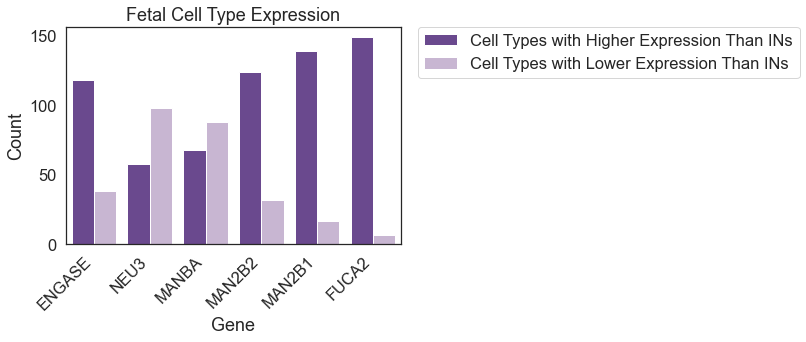

In [42]:
sns.set(font_scale = 1.5)
sns.set_style("white")
palette = {"Cell Types with Higher Expression Than INs": "#6A3D9A", "Cell Types with Lower Expression Than INs": "#CAB2D6"}
#ax = sns.barplot(x="Gene", y="Count", hue="Type", data=df, palette = palette).set(title = "Fetal Cross Tissue Expression")
plt.xticks(rotation=45, ha='right')
ax = sns.barplot(x="Gene", y="Count", hue="Type", data=df, palette = palette).set(title = "Fetal Cell Type Expression")
plt.legend(bbox_to_anchor= (1.05, 1), loc='upper left', borderaxespad=0, frameon=True)

In [102]:
#Generate the intersection of the L2FC vs MWU pval and MWU pval vs DESeq2 pval enrichments.
v = pd.read_csv("AGSEA_MWU_p-val_L2FC_Rank_Rank_Dif_Combined_SignTest.csv")
q = pd.read_csv("AGSEA_MWU_p-val_DESeq2_p-val_Rank_Rank_Dif_Combined_SignTest.csv")
v_lsit = []
q_lsit = []
for index, row in v.iterrows():
    mid = row["File"].split("_")
    check = mid[0] + "_" + mid[1] + "_" + row["Term"]
    v_lsit.append(check)
for index, row in q.iterrows():
    mid = row["File"].split("_")
    check = mid[0] + "_" + mid[1] + "_" + row["Term"]
    q_lsit.append(check)
    
s = list(set(v_lsit) & set(q_lsit))

o = []
for index, row in v.iterrows():
    mid = row["File"].split("_")
    check = mid[0] + "_" + mid[1] + "_" + row["Term"]
    if check in s:
        o.append([check] + list(row))
for index, row in q.iterrows():
    mid = row["File"].split("_")
    check = mid[0] + "_" + mid[1] + "_" + row["Term"]
    if check in s:
        o.append([check] + list(row))

df = pd.DataFrame(o)
df.columns = ["ID"] + list(v.columns)
df.to_csv("AGSEA_Intersect_L2FCdif_pvaldif.csv")

In [29]:
def extract_gene_info(genes, cell, data):
    name = "Gluconeogenesis"
    scores = pd.read_csv(cell + "_Scores_" + data + ".csv")
    ase = pd.read_csv("Rachel_ASE_Values_" + cell + ".csv").set_index("Gene")
    scores = scores.set_index("0")
    c_neg = 0
    tot = 0
    out = []
    for gene in genes.split(";"):
        try:
            score = list(scores.loc[gene])
            score[0] = (ase.loc[gene][0] + ase.loc[gene][1])/2
            out.append([gene] + score)
            if (ase.loc[gene][0] + ase.loc[gene][1])/2 < 0:
                c_neg += 1
                tot += 1
            elif (ase.loc[gene][0] + ase.loc[gene][1])/2 > 0:
                tot += 1
        except:
            pass
    df = pd.DataFrame(out)
    l = list(scores.columns)
    l[0] = "L2FC signed"
    df.columns = ["Gene"] + l
    df.to_csv("Ledge_genes_info_" + name + "_" + cell + "_" + data + ".csv", index = False)
    return cell, data, stats.binom_test(c_neg, tot, 0.5), c_neg, tot
extract_gene_info("ENO3;MDH1;GPI;SLC25A13;PC;PRKACB;ENO1;MDH2;ENO2;GOT2;GAPDH;FBP2;SLC25A10;ALDOB", "D50", "GTEX")

('D50', 'GTEX', 0.0001220703125, 14, 14)

In [9]:
#Split by in up in human or down in human and sort and compute the differences in ranks.
cells = ["D50", "D100", "D150"]
data = ["Stein"]
for cell in cells:
    s = pd.read_csv("Rachel_ASE_Values_" + cell + "_NoNA.csv")
    down = []
    up = []
    for index, row in s.iterrows():
        if (row[1] + row[2])/2 < 0:
            down.append(row[0])
        elif (row[1] + row[2])/2 > 0:
            up.append(row[0])
    for d in data:
        
        r = pd.read_csv(cell + "_Ranks_ABS_" + d  + ".csv")
        out_up = []
        out_down = []
        for index, row in r.iterrows():
            if row[0] in up:
                out_up.append(list(row))
            elif row[0] in down:
                out_down.append(list(row))
        df_up = pd.DataFrame(out_up)
        df_up.columns = r.columns
        df_up = df_up.sort_values("MWU p-val Rank", ascending = True)
        df_up["MWU p-val Rank"] = range(1, len(list(df_up.index)) + 1)
        df_up = df_up.sort_values("L2FC Rank", ascending = True)
        df_up["L2FC Rank"] = range(1, len(list(df_up.index)) + 1)
        df_up = df_up.sort_values("DESeq2 p-val Rank", ascending = True)
        df_up["DESeq2 p-val Rank"] = range(1, len(list(df_up.index)) + 1)
        df_up["MWU p-val DESeq2 p-val Rank Rank Dif"] = df_up["MWU p-val Rank"] - df_up["DESeq2 p-val Rank"]
        df_up["MWU p-val L2FC Rank Rank Dif"] = df_up["MWU p-val Rank"] - df_up["L2FC Rank"]
        df_up.to_csv(cell + "_Ranks_ABS_" + d + "_Up_Human.csv", index = False)
        df_down = pd.DataFrame(out_down)
        df_down.columns = r.columns
        df_down = df_down.sort_values("MWU p-val Rank", ascending = True)
        df_down["MWU p-val Rank"] = range(1, len(list(df_down.index)) + 1)
        df_down = df_down.sort_values("L2FC Rank", ascending = True)
        df_down["L2FC Rank"] = range(1, len(list(df_down.index)) + 1)
        df_down = df_down.sort_values("DESeq2 p-val Rank", ascending = True)
        df_down["DESeq2 p-val Rank"] = range(1, len(list(df_down.index)) + 1)
        df_down["MWU p-val DESeq2 p-val Rank Rank Dif"] = df_down["MWU p-val Rank"] - df_down["DESeq2 p-val Rank"]
        df_down["MWU p-val L2FC Rank Rank Dif"] = df_down["MWU p-val Rank"] - df_down["L2FC Rank"]
        df_down.to_csv(cell + "_Ranks_ABS_" + d + "_Down_Human.csv", index = False)
        print(df_up.head())
        print(df_down.head())

         gene  MWU p-val Rank  L2FC Rank  DESeq2 p-val Rank  \
710      GCN1            1059          1                  1   
318   CDK2AP1            1204          2                  2   
850     IL17D             492          3                  3   
1203    NPAS3             817          9                  4   
425    CREBZF            1258          4                  5   

      MWU p-val DESeq2 p-val Rank Rank Dif  MWU p-val L2FC Rank Rank Dif  
710                                   1058                          1058  
318                                   1202                          1202  
850                                    489                           489  
1203                                   813                           808  
425                                   1253                          1254  
         gene  MWU p-val Rank  L2FC Rank  DESeq2 p-val Rank  \
2192   ZCCHC9             550          3                  1   
556     EGLN1             808          5     

In [10]:
#Compute signed ranks.
#This means that negative ASE genes are at the bottom and positive ASE genes are at the top.
for cell in ["D50", "D100", "D150"]:
    for d in ["GTEX", "Stein"]:
        v_up = pd.read_csv(cell + "_Ranks_ABS_" + d + "_Up_Human.csv")
        v_up = v_up.set_index("gene")
        v_down = pd.read_csv(cell + "_Ranks_ABS_" + d + "_Down_Human.csv")
        v_down = v_down.set_index("gene")
        p = pd.DataFrame()
        v_down["MWU p-val Rank"] = -1*v_down["MWU p-val Rank"]
        v_down["L2FC Rank"] = -1*v_down["L2FC Rank"]
        v_down["DESeq2 p-val Rank"] = -1*v_down["DESeq2 p-val Rank"]
        
        c = -len(list(v_down.index))
        v_down = v_down.sort_values("MWU p-val DESeq2 p-val Rank Rank Dif", ascending = False)
        for index, row in v_down.iterrows():
            v_down["MWU p-val DESeq2 p-val Rank Rank Dif"][index] = c
            c += 1
        c = len(list(v_up.index))
        v_up = v_up.sort_values("MWU p-val DESeq2 p-val Rank Rank Dif", ascending = False)
        for index, row in v_up.iterrows():
            v_up["MWU p-val DESeq2 p-val Rank Rank Dif"][index] = c
            c -= 1
        
        c = -len(list(v_down.index))
        v_down = v_down.sort_values("MWU p-val L2FC Rank Rank Dif", ascending = False)
        for index, row in v_down.iterrows():
            v_down["MWU p-val L2FC Rank Rank Dif"][index] = c
            c += 1
        c = len(list(v_up.index))
        v_up = v_up.sort_values("MWU p-val L2FC Rank Rank Dif", ascending = False)
        for index, row in v_up.iterrows():
            v_up["MWU p-val L2FC Rank Rank Dif"][index] = c
            c -= 1
        
        v = pd.concat([v_up, v_down])
        v.to_csv(cell + "_Ranks_ABS_" + d + "_Signed.csv")

In [101]:
#Add sign information to the extracted gene information.
csv = pd.read_csv("Ledge_genes_info_Neuronal_Cell_Body_Sign_D100_GTEX.csv")
ra = pd.read_csv("ARachel_Parental_ASE.csv")
ra = ra.set_index("Gene")
d = {}
for index, row in csv.iterrows():
    d[row[0]] = []
for index, row in ra.iterrows():
    if index in d.keys():
        d[index] = [row["Day100_LFC"], row["Day100_padj"]]

def sign(x):
    if x < 0:
        return -1
    elif x > 0:
        return 1
o = []
for index, row in csv.iterrows():
    l = list(row) + d[row[0]]
    o.append(l + [sign(l[1]) == sign(l[4])])
df = pd.DataFrame(o)
df.columns = list(csv.columns) + ["Parental L2FC D100", "Parental DESeq2 p-val D100", "Parental Hybrid Agree?"]

df.to_csv("Ledge_genes_info_Neuronal_Cell_Body_Sign_D100_GTEX_Aug.csv")

D50 SpearmanrResult(correlation=0.9203019708416191, pvalue=0.0)
D100 SpearmanrResult(correlation=0.924114473839885, pvalue=0.0)
D50 SpearmanrResult(correlation=0.9203019708416191, pvalue=0.0)


C:\Users\astar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'GTEx Mann Whitney p-value Rank')

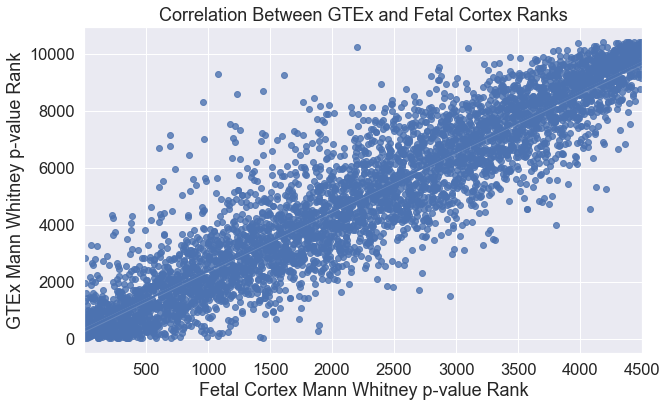

In [9]:
#Compute the rank based correlation for the Stein and GTEX data
cells = ["D50", "D100", "D50"]
for cell in cells:
    csv1 = pd.read_csv(cell + "_Ranks_NoCut_Stein.csv")
    csv2 = pd.read_csv(cell + "_Ranks_NoCut_GTEX.csv")
    l = []
    keep = []
    for index, row in csv1.iterrows():
        l.append(row[0])
    for index, row in csv2.iterrows():
        if row[0] in l:
            keep.append(row[0])
    csv1 = csv1.set_index("gene")
    csv2 = csv2.set_index("gene")
    csv1 = csv1.loc[keep]
    csv2 = csv2.loc[keep]
    print(cell, stats.spearmanr(csv1["MWU p-val Rank"], csv2["MWU p-val Rank"]))
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style("white")
sns.regplot(csv1["MWU p-val Rank"], csv2["MWU p-val Rank"]).set(title = "Correlation Between GTEx and Fetal Cortex Ranks")
ax.set_xlabel("Fetal Cortex Mann Whitney p-value Rank")
ax.set_ylabel("GTEx Mann Whitney p-value Rank")

C:\Users\astar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'GTEx Mann Whitney p-value rank')

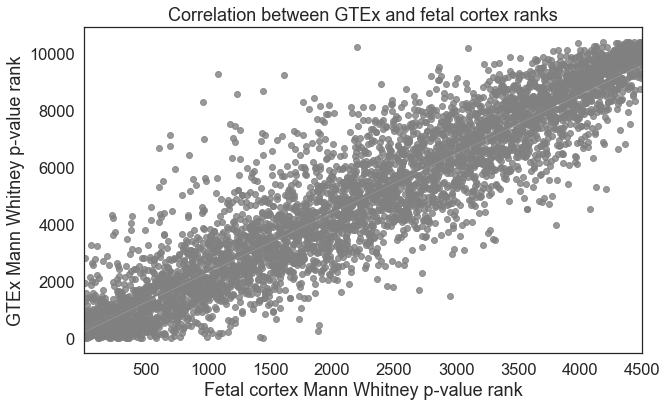

In [10]:
sns.set(font_scale = 1.5)
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,6))

sns.regplot(csv1["MWU p-val Rank"], csv2["MWU p-val Rank"], color = "grey").set(title = "Correlation between GTEx and fetal cortex ranks")
ax.set_xlabel("Fetal cortex Mann Whitney p-value rank")
ax.set_ylabel("GTEx Mann Whitney p-value rank")

In [11]:
#Remove outliers?
#List of imprinted genes was obtained from https://www.geneimprint.com/site/genes-by-species
imp = pd.read_csv("Imprinted_Genes.csv")
imp_conf = imp[imp["Status"] == "Imprinted"]
imp_conf_list = list(imp_conf["Gene"])
d = {}
for index, row in pd.read_csv("D150_GTEX_MinReads_Per_Allele10Variance_Mean.txt", sep = "\t").dropna().iterrows():
    if row["Size"] >= 10 and row[0] not in imp_conf_list:
        d[row[0]] = [row[1]]
for index, row in pd.read_csv("Haploinsufficiency_Score_Predictions.csv").iterrows():
    if row[0] in d.keys():
        d[row[0]].append(row[1])
pHI = []
Var = []
o = []
for key in d.keys():
    if len(d[key]) > 1:
        pHI.append(1-d[key][1])
        Var.append(d[key][0])
        if d[key][1] < 0.2:
            o.append([d[key][0], "0 <= pHI < 0.2"])
        elif d[key][1] < 0.4:
            o.append([d[key][0], "0.2 <= pHI < 0.4"])
        elif d[key][1] < 0.6:
            o.append([d[key][0], "0.4 <= pHI < 0.6"])
        elif d[key][1] < 0.8:
            o.append([d[key][0], "0.6 <= pHI < 0.8"])
        else:
            o.append([d[key][0], "0.8 <= pHI <= 1.0"])
print(stats.spearmanr(pHI, Var), len(Var))


SpearmanrResult(correlation=0.281109955425957, pvalue=8.12246895894846e-174) 9599


[Text(0.5, 1.0, 'Relationship for pHI and GTEx distribution variance')]

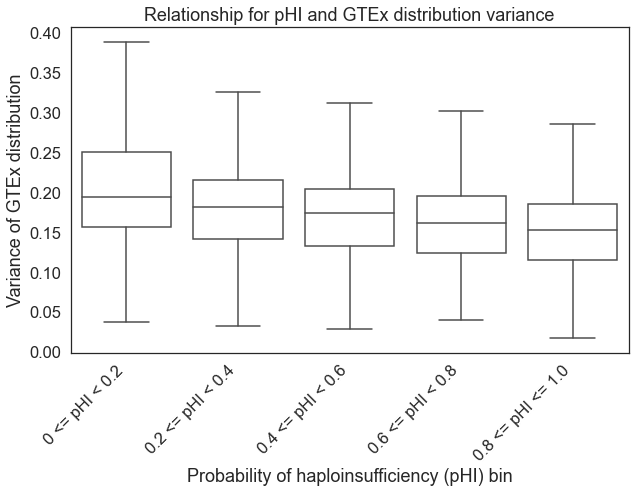

In [13]:

sns.set(font_scale = 1.5)
sns.set_style("white")
df = pd.DataFrame(o)
fig, ax = plt.subplots(figsize=(10,6))
df.columns = ["Variance of GTEx distribution", "Probability of haploinsufficiency (pHI) bin"]
sns.set(font_scale = 1.5)
order = ["0 <= pHI < 0.2", "0.2 <= pHI < 0.4", "0.4 <= pHI < 0.6", "0.6 <= pHI < 0.8", "0.8 <= pHI <= 1.0"]
ax = sns.boxplot(x="Probability of haploinsufficiency (pHI) bin", y="Variance of GTEx distribution", data=df, showfliers=False, order = order, boxprops={'facecolor':'None'})
plt.legend([],[], frameon=False)
plt.xticks(rotation = 45, ha = "right")
#ax.set_xlabel("Relationship for pHI and GTEx Distribution Variance")
sns.set_style("white")
ax.set(title="Relationship for pHI and GTEx distribution variance")


C:\Users\astar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

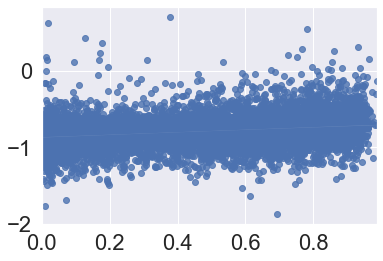

In [18]:
sns.set(font_scale = 2)
sns.regplot(pHI, np.log10(Var))

In [25]:
#Compute the average ASE value for the top 100 genes in D150 GTEX and D150 Stein
csv = pd.read_csv("D150_Scores_GTEX.csv")
csv2 = pd.read_csv("D150_Scores_Stein.csv")


,0,L2FC Score,ASE p-val Score,DESeq2 p-val Score
0,A2M,0.174835,0.401983,0.802288
1,AACS,0.202368,0.101267,0.353558
2,AAGAB,0.015799,0.306778,0.913365
3,AAK1,0.126843,0.115457,0.449635
4,ABAT,0.425349,0.001639,0.000606
...,...,...,...,...
4479,ZSCAN29,0.444425,0.007333,0.000360
4480,ZSWIM6,0.434688,0.002453,0.230339
4481,ZWINT,0.577496,0.007931,0.001741
4482,ZXDC,0.282413,0.001936,0.024784


In [90]:
genes = []
keep = []
for index, row in csv.iterrows():
    genes.append(row[0])
for index, row in csv2.iterrows():
    if row[0] in genes:
        keep.append(row[0])

In [91]:
csv2 = csv2.sort_values("ASE p-val Score")

In [92]:

l2 = []
i2 = 0
for index, row in csv2.iterrows():
    
    if i2 > 100:
        break
    elif row[0] in keep:
        i2 += 1
        l2.append(row[1])

In [93]:
csv = csv.sort_values("ASE p-val Score")
l = []
i = 0
for index, row in csv.iterrows():
    if i > 100:
        break
    elif row[0] in keep:
        i += 1
        l.append(row[1])

In [94]:
np.median(l)

1.06776538

In [95]:

from scipy.stats import mannwhitneyu
np.median(l2)

0.7847329725

In [96]:
print(mannwhitneyu(l, l2))

MannwhitneyuResult(statistic=3363.5, pvalue=1.4558315023494355e-05)


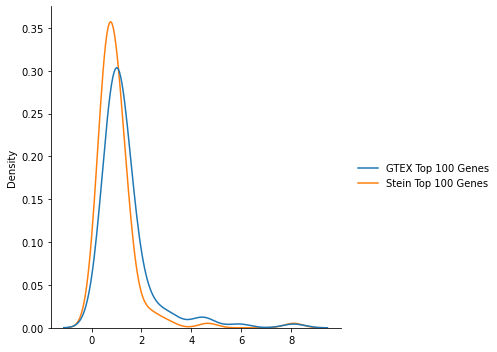

In [97]:
sns.displot({"GTEX Top 100 Genes":l, "Stein Top 100 Genes":l2}, kind = "kde")

In [29]:
#Compute the average ASE value for the top 100 genes in D150 GTEX and D150 Stein
csv = pd.read_csv("D150_Ranks_GTEX.csv")
csv2 = pd.read_csv("D150_Ranks_Stein.csv")
sns.set(font_scale = 1)
csv = csv.set_index("gene")
csv2 = csv2.set_index("gene")
csv2.columns = ['GMWU p-val Rank', 'GL2FC Rank', 'GDESeq2 p-val Rank', 'GMWU p-val DESeq2 p-val Rank Rank Dif', 'GMWU p-val L2FC Rank Rank Dif']
j = csv2.join(csv)
print(spearmanr(j["GMWU p-val Rank"]), )

,GMWU p-val Rank,GL2FC Rank,GDESeq2 p-val Rank,GMWU p-val DESeq2 p-val Rank Rank Dif,GMWU p-val L2FC Rank Rank Dif,MWU p-val Rank,L2FC Rank,DESeq2 p-val Rank,MWU p-val DESeq2 p-val Rank Rank Dif,MWU p-val L2FC Rank Rank Dif
gene,,,,,,,,,,
GRID1,2685,345,106,2579,2340,5525.0,662.0,257.0,5268.0,4863.0
UBE3A,2651,178,142,2509,2473,1528.0,311.0,354.0,1174.0,1217.0
VPS50,2526,146,140,2386,2380,4732.0,262.0,348.0,4384.0,4470.0
MKI67,2877,945,552,2325,1932,5296.0,1795.0,1248.0,4048.0,3501.0
PDE2A,2413,242,138,2275,2171,6023.0,456.0,345.0,5678.0,5567.0
...,...,...,...,...,...,...,...,...,...,...
LMO4,477,2369,2834,-2357,-1892,1272.0,4698.0,6353.0,-5081.0,-3426.0
FNTA,389,2493,2831,-2442,-2104,2615.0,4983.0,6350.0,-3735.0,-2368.0
RNF139,202,2509,2659,-2457,-2307,2736.0,5026.0,5980.0,-3244.0,-2290.0


In [3]:
#Remove outliers?
#List of imprinted genes was obtained from https://www.geneimprint.com/site/genes-by-species
imp = pd.read_csv("Imprinted_Genes.csv")
imp_conf = imp[imp["Status"] == "Imprinted"]
imp_conf_list = list(imp_conf["Gene"])
d = {}
for index, row in pd.read_csv("D150_GTEX_MinReads_Per_Allele10Variance_Mean.txt", sep = "\t").dropna().iterrows():
    if row["Size"] >= 10 and row[0] not in imp_conf_list:
        d[row[0]] = [row[1]]
for index, row in pd.read_csv("Haploinsufficiency_Score_Predictions.csv").iterrows():
    if row[0] in d.keys():
        d[row[0]].append(row[1])
pHI = []
Var = []
o = []
for key in d.keys():
    if len(d[key]) > 1:
        pHI.append(1-d[key][1])
        Var.append(d[key][0])
        if d[key][1] < 0.2:
            o.append([d[key][0], "0 <= pHI < 0.2"])
        elif d[key][1] < 0.4:
            o.append([d[key][0], "0.2 <= pHI < 0.4"])
        elif d[key][1] < 0.6:
            o.append([d[key][0], "0.4 <= pHI < 0.6"])
        elif d[key][1] < 0.8:
            o.append([d[key][0], "0.6 <= pHI < 0.8"])
        else:
            o.append([d[key][0], "0.8 <= pHI <= 1.0"])
print(stats.spearmanr(pHI, Var), len(Var))


SpearmanrResult(correlation=0.281109955425957, pvalue=8.12246895894846e-174) 9599


In [21]:
v = pd.read_csv("Rachel_ASE_Values_D150_NoNA.csv")
k = []
d_sig_ase = {}
d_all_ase = {}
for index, row in v.iterrows():
    if row["D150_HumanPadj"] < 0.05:
        k.append(row["Gene"])
        d_sig_ase[row["Gene"]] = [(row["D150_HumanLFC"] + row["D150_ChimpLFC"])/2]
    d_all_ase[row["Gene"]] = [(row["D150_HumanLFC"] + row["D150_ChimpLFC"])/2]

In [5]:
v

,Gene,D150_HumanLFC,D150_ChimpLFC,D150_HumanPadj,D150_ChimpPadj
0,A1BG,1.078321,1.086439,0.000072,0.000127
1,A1CF,0.009657,-0.043032,NaN,NaN
2,A2M,0.205628,0.144042,0.763144,0.841433
3,A2ML1,-0.376711,-0.396633,0.760105,0.695130
4,A4GALT,-0.047156,0.061964,0.918579,0.894240
...,...,...,...,...,...
12918,ZWINT,0.580251,0.574741,0.001833,0.001649
12919,ZXDC,-0.309442,-0.255383,0.001507,0.048060
12920,ZYG11B,-0.207163,-0.140881,0.005608,0.083182
12921,ZZEF1,-0.218508,-0.199782,0.000563,0.002633


In [20]:
#Remove outliers?
#List of imprinted genes was obtained from https://www.geneimprint.com/site/genes-by-species
imp = pd.read_csv("Imprinted_Genes.csv")
imp_conf = imp[imp["Status"] == "Imprinted"]
imp_conf_list = list(imp_conf["Gene"])
for index, row in pd.read_csv("Haploinsufficiency_Score_Predictions.csv").iterrows():
    if row[0] in d_sig_ase.keys():
        d_sig_ase[row[0]].append(row[1])
pHI = []
Var = []
o = []
for key in d_sig_ase.keys():
    if len(d_sig_ase[key]) > 1:
        pHI.append(1-d_sig_ase[key][1])
        Var.append(d_sig_ase[key][0])
        if d_sig_ase[key][1] < 0.2:
            o.append([d_sig_ase[key][0], "0 <= pHI < 0.2"])
        elif d_sig_ase[key][1] < 0.4:
            o.append([d_sig_ase[key][0], "0.2 <= pHI < 0.4"])
        elif d_sig_ase[key][1] < 0.6:
            o.append([d_sig_ase[key][0], "0.4 <= pHI < 0.6"])
        elif d_sig_ase[key][1] < 0.8:
            o.append([d_sig_ase[key][0], "0.6 <= pHI < 0.8"])
        else:
            o.append([d_sig_ase[key][0], "0.8 <= pHI <= 1.0"])
print(stats.spearmanr(pHI, Var), len(Var))


[1.0823798175000001,
 -1.467722687,
 3.1963219895,
 -0.2665377135,
 0.42534931200000003,
 -1.7808770245,
 0.2970721205,
 -0.6982240155,
 0.760333157,
 -0.9637501215,
 0.356721204,
 -0.554903967,
 1.5879311115,
 -0.3159111105,
 0.284721868,
 -0.34486728349999995,
 -0.769796161,
 0.621614192,
 -1.0595737175,
 0.4457092055,
 0.558977091,
 0.428215341,
 -0.728034795,
 0.7112606674999999,
 1.2631070875,
 0.3373620585,
 -1.0023902814999999,
 0.3503101705,
 -0.2375401405,
 0.465456326,
 -0.22801978950000001,
 2.4760995365,
 -0.3623313635,
 -0.875313633,
 -0.299105098,
 1.9133452489999998,
 -4.360894441499999,
 0.9821744725,
 -0.21151405500000003,
 -1.9329622605,
 0.1649038155,
 -0.4146468715,
 -0.30395801850000004,
 -0.8174889439999999,
 -0.530452658,
 -0.9577322925,
 1.0519129839999999,
 1.2593905795,
 0.19780968999999998,
 0.24039669749999998,
 -3.8349288085,
 0.21477906750000003,
 -1.7151596009999999,
 -0.6027575895,
 -0.47326892649999996,
 0.410116143,
 -0.24811234000000001,
 0.8875169275

In [7]:
#Remove outliers?
#List of imprinted genes was obtained from https://www.geneimprint.com/site/genes-by-species
imp = pd.read_csv("Imprinted_Genes.csv")
imp_conf = imp[imp["Status"] == "Imprinted"]
imp_conf_list = list(imp_conf["Gene"])
d = {}
for index, row in pd.read_csv("D150_GTEX_MinReads_Per_Allele10Variance_Mean.txt", sep = "\t").dropna().iterrows():
    if row["Size"] >= 10 and row[0] not in imp_conf_list:
        d[row[0]] = [row[1]]
for index, row in pd.read_csv("gnomad_pli.txt", sep = "\t").iterrows():
    if row[0] in d.keys():
        d[row[0]].append(row[1])
pHI = []
Var = []
o = []
for key in d.keys():
    if len(d[key]) > 1:
        pHI.append(1-d[key][1])
        Var.append(d[key][0])
        if d[key][1] < 0.2:
            o.append([d[key][0], "0 <= pLI < 0.2"])
        elif d[key][1] < 0.4:
            o.append([d[key][0], "0.2 <= pLI < 0.4"])
        elif d[key][1] < 0.6:
            o.append([d[key][0], "0.4 <= pLI < 0.6"])
        elif d[key][1] < 0.8:
            o.append([d[key][0], "0.6 <= pLI < 0.8"])
        else:
            o.append([d[key][0], "0.8 <= pLI <= 1.0"])
print(stats.spearmanr(pHI, Var), len(Var))


SpearmanrResult(correlation=0.21950598283185352, pvalue=1.9177865000048037e-107) 9820


[Text(0.5, 1.0, 'Relationship for pLI and GTEx Distribution Variance')]

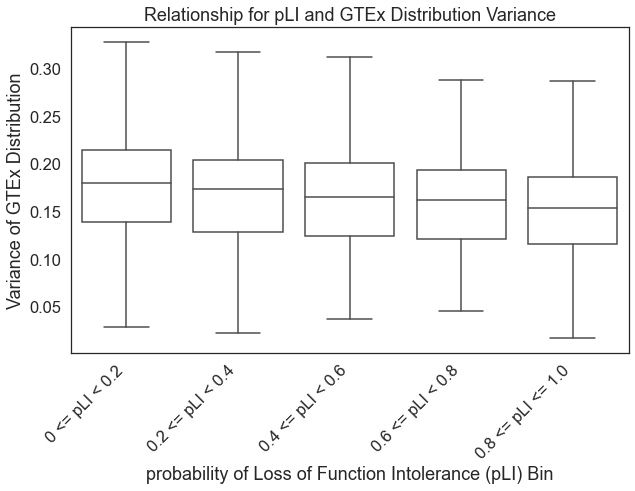

In [8]:

sns.set(font_scale = 1.5)
sns.set_style("white")
df = pd.DataFrame(o)
fig, ax = plt.subplots(figsize=(10,6))
df.columns = ["Variance of GTEx Distribution", "probability of Loss of Function Intolerance (pLI) Bin"]
sns.set(font_scale = 1.5)
order = ["0 <= pLI < 0.2", "0.2 <= pLI < 0.4", "0.4 <= pLI < 0.6", "0.6 <= pLI < 0.8", "0.8 <= pLI <= 1.0"]
ax = sns.boxplot(x="probability of Loss of Function Intolerance (pLI) Bin", y="Variance of GTEx Distribution", data=df, showfliers=False, order = order, boxprops={'facecolor':'None'})
plt.legend([],[], frameon=False)
plt.xticks(rotation = 45, ha = "right")
#ax.set_xlabel("Relationship for pHI and GTEx Distribution Variance")
sns.set_style("white")
ax.set(title="Relationship for pLI and GTEx Distribution Variance")
